# Setup

In [ ]:
!pip install gmpy2
!pip install tensorflow

     |████████████████████████████████| 3.6 MB 9.6 MB/s 
     |████████████████████████████████| 462 kB 4.5 MB/s 


In [ ]:
%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import load_model

# Symmetric (secret-key) encryption


### Two-Eve Model

In the CNN model built using 1 eve(adversary) the accuracy or strength of encryption depended mainly on eve's capability to reconstruct the original plaintext. But since we were using only 1 eve, the efficiency of the model was only dependent on eve loss. Hence alice could forget the involvement of the secret key entirely since the loss function did not take the key into account.


Hence we are introducing here another adversary:- eve2 whose sole purpose is to recover the secret key.In this new model, we have two attackers Eve1 and Eve2 with different attacking goals. Eve1 focuses on recovering the plaintext and Eve2’s goal is to recover the secret key. In this model, Alice cannot simply ignore the involve-ment of the secret key due to the existence of Eve.

In [ ]:
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

m_train = (m_bits+ k_bits)

### Architecture

In [ ]:
K.clear_session()

##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)


alice_model = keras.Sequential(
    [
        layers.Dense(units=(m_bits + k_bits),activation="tanh"),
        layers.Reshape((m_bits + k_bits, 1,)),
        layers.Conv1D(filters=2, kernel_size=4, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=2, strides=2, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=1, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=1, kernel_size=1, strides=1, padding=pad,activation="sigmoid"),
        layers.Flatten(),
    ]
)
alice_model.compile(loss='mse', optimizer='sgd')
alice=alice_model(ainput)


##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bob_model = keras.Sequential(
    [
        layers.Dense(units=(c_bits + k_bits),activation="tanh"),
        layers.Reshape((c_bits + k_bits, 1,)),
        layers.Conv1D(filters=2, kernel_size=4, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=2, strides=2, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=1, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=1, kernel_size=1, strides=1, padding=pad,activation="sigmoid"),
        layers.Flatten(),
    ]
)
bob_model.compile(loss='mse', optimizer='sgd')
bob=bob_model(binput)
#bob.summary()


# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only
eve1_model = keras.Sequential(
    [
        layers.Dense(units=(c_bits + k_bits),activation="tanh"),
        layers.Reshape((c_bits + k_bits, 1,)),
        layers.Conv1D(filters=2, kernel_size=4, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=2, strides=2, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=1, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=1, kernel_size=1, strides=1, padding=pad,activation="sigmoid"),
        layers.Flatten(),
    ]
)
eve1_model.compile(loss='mse', optimizer='sgd')
eve1=eve1_model(einput)
#eve.summary()

# Eve2 network
#
einput2 = Input(shape=(k_bits,)) #key only
eve2_model = keras.Sequential(
    [
        layers.Dense(units=(c_bits + k_bits),activation="tanh"),
        layers.Dense(units=(c_bits + k_bits),activation="tanh"),
        layers.Reshape((c_bits + k_bits, 1,)),
        layers.Conv1D(filters=2, kernel_size=4, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=2, strides=2, padding=pad,activation="tanh"),
        layers.Conv1D(filters=4, kernel_size=1, strides=1, padding=pad,activation="tanh"),
        layers.Conv1D(filters=1, kernel_size=1, strides=1, padding=pad,activation="sigmoid"),
        layers.Flatten(),
    ]
)
eve2_model.compile(loss='mse', optimizer='sgd')
eve2=eve2_model(einput2)

### Loss + Optimizer

In [ ]:
aliceout = alice_model(concatenate([ainput0, ainput1],axis=1))
bobout = bob_model( concatenate([aliceout, binput1], axis=1))
eveout = eve1_model(aliceout)
eve2out = eve2_model(aliceout)

eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )
eve2loss = K.mean(  K.sum(K.abs(ainput1 - eve2out), axis=-1)  )

bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + (K.square(m_bits/2 - eveloss)+K.square(k_bits/2- eve2loss))/( (m_bits//2)**2 )

abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) 
eveoptim2 = RMSprop(lr=0.001) 

abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

alice_model.trainable = False
eve1_model = Model([ainput0, ainput1], eveout, name='evemodel')
eve1_model.add_loss(eveloss)
eve1_model.compile(optimizer=eveoptim)

alice_model.trainable = False
eve2_model = Model([ainput0, ainput1], eve2out, name='eve2model')
eve2_model.add_loss(eve2loss)
eve2_model.compile(optimizer=eveoptim2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Train / save / restore

In [ ]:
abelosses = []
boblosses = []
evelosses = []
eve2losses = []

In [ ]:
epoch_count = 20
batch_size = 512
n_batches = 128

abecycles = 1
evecycles = 2

print("Training ", epoch_count, "epochs using", n_batches, "batches of size", batch_size)
print("------------------------------------------------")
for epoch in range(1,epoch_count):
    abe_losses = []
    bob_losses = []
    eve1_losses = []
    eve2_losses = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice_model.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch,k_batch], None)
            abe_losses.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abe_losses)

        ainp=concatenate([m_batch, k_batch], axis=1)
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice_model.predict(ainp)
        #print(type(m_enc),type(k_batch))
        binp=concatenate([m_enc,tf.cast(k_batch,tf.float64)],axis=1)  
        m_dec = bob_model.predict(binp)
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        bob_losses.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(bob_losses)
        
        # Train the EVE network
        #
        alice_model.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve1_model.train_on_batch([m_batch, k_batch], None)
            eve1_losses.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(eve1_losses)
        # Train the EVE2 network
        #
        alice_model.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve2_model.train_on_batch([m_batch, k_batch], None)
            eve2_losses.append(loss)
        eve2losses.append(loss)
        eve2avg = np.mean(eve2_losses)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve1: {:2.3f} | eve2: {:2.3f}| bob: {:2.3f}".format(epoch, 100 * iteration // n_batches, abeavg, eveavg, eve2avg,bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training  20 epochs using 128 batches of size 512
------------------------------------------------
Epoch   1:  99% | abe: 7.789 | eve1: 7.902 | eve2: 7.875| bob: 7.776
Epoch   2:  99% | abe: 5.836 | eve1: 7.093 | eve2: 7.493| bob: 5.785
Epoch   3:  99% | abe: 3.680 | eve1: 5.527 | eve2: 7.185| bob: 3.535
Epoch   4:  99% | abe: 2.183 | eve1: 3.849 | eve2: 7.047| bob: 1.860
Epoch   5:  99% | abe: 1.239 | eve1: 2.616 | eve2: 6.980| bob: 0.742
Epoch   6:  99% | abe: 0.834 | eve1: 2.124 | eve2: 6.772| bob: 0.254
Epoch   7:  99% | abe: 0.705 | eve1: 2.346 | eve2: 6.337| bob: 0.144
Epoch   8:  99% | abe: 0.617 | eve1: 2.767 | eve2: 5.866| bob: 0.100
Epoch   9:  99% | abe: 0.565 | eve1: 3.135 | eve2: 5.446| bob: 0.077
Epoch  10:  99% | abe: 0.557 | eve1: 3.321 | eve2: 5.094| bob: 0.064
Epoch  11:  99% | abe: 0.572 | eve1: 3.400 | eve2: 4.777| bob: 0.059
Epoch  12:  99% | abe: 0.588 | eve1: 3.407 | eve2: 4.532| bob: 0.051
Epoch  13:  99% | abe: 0.609 | eve1: 3.393 | eve2: 4.386| bob: 0.053
Epoc

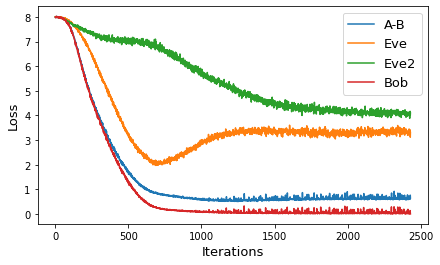

In [ ]:
def plot4(abelosses,evelosses,eve2losses,boblosses):
    steps = -1
    plt.figure(figsize=(7, 4))
    plt.plot(abelosses[:steps], label='A-B')
    plt.plot(evelosses[:steps], label='Eve')
    plt.plot(eve2losses[:steps], label='Eve2')
    plt.plot(boblosses[:steps], label='Bob')
    plt.xlabel("Iterations", fontsize=13)
    plt.ylabel("Loss", fontsize=13)
    plt.legend(fontsize=13)

    #plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
    plt.show()
plot4(abelosses,evelosses,eve2losses,boblosses)

### Evaluate

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
ainp=concatenate([m_batch,k_batch], axis=1)
m_enc = alice_model.predict(ainp)
m_dec = (bob_model.predict(concatenate([m_enc, tf.cast(k_batch,tf.float64)],axis=1)) > 0.5).astype(int)
m_att = (eve1_model.predict([m_enc,tf.cast(k_batch,tf.float64)]) > 0.5).astype(int)
k_att = (eve2_model.predict([m_enc,tf.cast(k_batch,tf.float64)]) > 0.5).astype(int)
bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)
ediff2 = np.abs(k_batch - k_att)
esum2 = np.sum(ediff2, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')
print("Eve2 key reconstruct % correct: ", 100.0*np.sum(esum2 == 0) / n_examples, '%')

Bob % correct:  98.45 %
Eve % correct:  0.0 %
Eve2 key reconstruct % correct:  2.0 %




### Improvement of Eve

In [ ]:
alice_model.trainable = False

abelosses = []
boblosses = []
evelosses = []
eve2losses=[]

In [ ]:
epoch_count = 20
batch_size = 512
n_batches = 128

abecycles = 1
evecycles = 2

print("Training ", epoch_count, "epochs using", n_batches, "batches of size", batch_size)
print("------------------------------------------------")
for epoch in range(1,epoch_count):
    abe_losses = []
    bob_losses = []
    eve1_losses = []
    eve2_losses = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice_model.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch,k_batch], None)
            abe_losses.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abe_losses)

        ainp=concatenate([m_batch, k_batch], axis=1)
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice_model.predict(ainp)
        #print(type(m_enc),type(k_batch))
        binp=concatenate([m_enc,tf.cast(k_batch,tf.float64)],axis=1)  
        m_dec = bob_model.predict(binp)
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        bob_losses.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(bob_losses)
        
        # Train the EVE network
        #
        alice_model.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve1_model.train_on_batch([m_batch, k_batch], None)
            eve1_losses.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(eve1_losses)
        # Train the EVE2 network
        #
        alice_model.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = eve2_model.train_on_batch([m_batch, k_batch], None)
            eve2_losses.append(loss)
        eve2losses.append(loss)
        eve2avg = np.mean(eve2_losses)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve1: {:2.3f} | eve2: {:2.3f}| bob: {:2.3f}".format(epoch, 100 * iteration // n_batches, abeavg, eveavg, eve2avg,bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training  20 epochs using 128 batches of size 512
------------------------------------------------
Epoch   1:  99% | abe: 0.646 | eve1: 3.425 | eve2: 4.064| bob: 0.054
Epoch   2:  99% | abe: 0.645 | eve1: 3.447 | eve2: 4.045| bob: 0.057
Epoch   3:  99% | abe: 0.643 | eve1: 3.479 | eve2: 4.000| bob: 0.054
Epoch   4:  99% | abe: 0.652 | eve1: 3.496 | eve2: 3.978| bob: 0.057
Epoch   5:  99% | abe: 0.657 | eve1: 3.479 | eve2: 3.967| bob: 0.062
Epoch   6:  99% | abe: 0.654 | eve1: 3.505 | eve2: 3.938| bob: 0.064
Epoch   7:  99% | abe: 0.656 | eve1: 3.544 | eve2: 3.931| bob: 0.064
Epoch   8:  99% | abe: 0.652 | eve1: 3.557 | eve2: 3.930| bob: 0.064
Epoch   9:  99% | abe: 0.649 | eve1: 3.603 | eve2: 3.891| bob: 0.059
Epoch  10:  99% | abe: 0.661 | eve1: 3.643 | eve2: 3.784| bob: 0.062
Epoch  11:  99% | abe: 0.669 | eve1: 3.616 | eve2: 3.682| bob: 0.056
Epoch  12:  99% | abe: 0.676 | eve1: 3.560 | eve2: 3.653| bob: 0.051
Epoch  13:  99% | abe: 0.681 | eve1: 3.556 | eve2: 3.627| bob: 0.053
Epoc

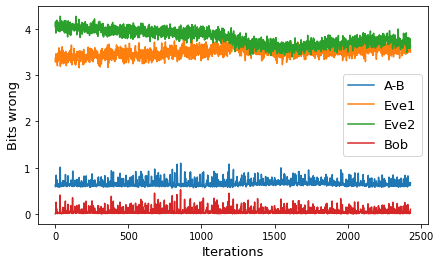

In [ ]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve1')
plt.plot(eve2losses[:steps], label='Eve2')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Bits wrong", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + "-eve1.png", transparent=True) #dpi=100
plt.show()

In [ ]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
ainp=concatenate([m_batch,k_batch], axis=1)
m_enc = alice_model.predict(ainp)
m_dec = (bob_model.predict(concatenate([m_enc, tf.cast(k_batch,tf.float64)],axis=1)) > 0.5).astype(int)
m_att = (eve1_model.predict([m_enc,tf.cast(k_batch,tf.float64)]) > 0.5).astype(int)
k_att = (eve2_model.predict([m_enc,tf.cast(k_batch,tf.float64)]) > 0.5).astype(int)
bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)
ediff2 = np.abs(k_batch - k_att)
esum2 = np.sum(ediff2, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')
print("Eve2 key reconstruct % correct: ", 100.0*np.sum(esum2 == 0) / n_examples, '%')

Bob % correct:  91.03 %
Eve % correct:  0.01 %
Eve2 key reconstruct % correct:  5.55 %
